In [299]:
from pylab import *

In [370]:
def calc_acc(pos, vel, drag_force, gravity, drag_coefs):
    if drag_force:
        drag = drag_coefs * vel**2
        if abs(gravity)< abs(drag):
            acc = 0.0
        else:
            acc = gravity + drag
        return acc
    else:
        return gravity

In [371]:
###############################################################################
# LEAPFROG 1 integrator 
# Source [The leapfrog method and other “symplectic” algorithms for integrating Newton’s laws of motion]
# Source [Lecture V: Time integration pdf]
# Wikipedia version 1

def integrate_LF(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = zeros(N)
    v_half = zeros(N)
    v_full = zeros(N)
    a = zeros(N+1)
    
    E = zeros(N)    
    Ek = zeros(N)
    Ep = zeros(N)    
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    
    #calculate intial V_{1/2} 
    v_half[0] = v0 + 0.5 * a * dt_
    
    #calculate intial energy Ek+Ep
    Ek[0] = 0.5 * v_full[0]**2 
    Ep[0] = -1 * a * x[0]
    E[0] = Ek[0] + Ep[0]
    
    ###########################################################################
    # integration    
    for i in range(N-1):
        #update position from n -> n+1
        x[i + 1] = x[i] + dt_ * v_half[i]        
        
        #update velocity from n+1/2 -> n+3/2
        v_half[i + 1] = v_half[i] + dt_ * a
        
        #update velocity from n -> n +1: This may only be correct if a is 
        #constant over complete time horizon...take average of V_1/2 and V_3/2
        #v_full[i + 1] = (v_half[i] + v_half[i+1]) / 2.0 

        #or maybe this is the same
        #as V_{n+1} = V_{n+3/2} - 1/2 * dt * a_{n+1} [Wikipedia], i.e.
        v_full[i + 1] = v_half[i + 1] - 0.5 * dt_ * a

        a = calc_acc(x[i+1], v_full[i + 1], drag_force, gravity, drag_coefs)

        Ek[i + 1] = 0.5 * v_full[i+1]**2 
        Ep[i + 1] =  -1 * a * x[i+1]
        
        #Calcualte energy Ek plus Ep
        E[i + 1] =  Ek[i + 1] + Ep[i + 1]    
        
    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E 

In [372]:
###############################################################################
# LEAPFROG 2 integrator [Wikipedia version 2 ] === Velocity Verlet
# https://www.uio.no/studier/emner/matnat/astro/AST2000/h18/undervisningsmateriell_h2018/Numerical%20Compendium/integration_of_differential_equations.pdf]
#Note, however, that this algorithm assumes that acceleration {n+1}
#only depends on position {n+1} and does not depend on velocity {n+1} {Wikipedia Velocity Verlet}

def integrate_VV(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = zeros(N)
    v_half = zeros(N)
    v_full = zeros(N)
    a = zeros(N+1)
    E = zeros(N)    
    Ek = zeros(N)
    Ep = zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    
    Ek[0] = 0.5 * v_full[0]**2 
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    Ep[0] = -1* a * x[0]
    E[0] = Ek[0] + Ep[0]
    
    ###########################################################################
    # integration    
    for i in range(N - 1):
        #update position from n -> n+1
        x[i + 1] = x[i] + dt_ * v_full[i] + 0.5 * a * dt_**2
        
        a_next = calc_acc(x[i], v_full[i], drag_force, gravity, drag_coefs)
        
        v_full[i + 1] = v_full[i] + 0.5 * dt_ * (a + a_next)
        
        a = a_next
        Ek[i + 1] = 0.5 * v_full[i+1]**2
        Ep[i + 1] = (-1 * a) * x[i+1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

In [373]:
def integrate_Beeman(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = zeros(N)
    v_half = zeros(N)
    v_full = zeros(N)
    a = zeros(N+1)
    E = zeros(N)    
    Ek = zeros(N)
    Ep = zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    
    Ek[0] = 0.5 * v_full[0]**2 
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    Ep[0] = -1* a * x[0]
    E[0] = Ek[0] + Ep[0]
    
    a_previous = 0.0
    two_per_3 = 2.0 / 3.0
    three_per_2 = 3.0 / 2.0
    one_per_6 = 1.0 / 6.0
    five_per_12 = 5.0 / 12.0
    one_per_12 = 1.0 / 12.0
    
    ###########################################################################
    # integration    
    for i in range(N-1):
        #update position from n -> n+1
        x[i + 1] = x[i] + dt_ * v_full[i]
        x[i + 1] += (two_per_3 * a - one_per_6 * a_previous) * dt_**2        
        
        #predicted velocity
        v_full[i + 1] = v_full[i] + dt_ * (three_per_2 * a - 0.5 * a_previous)

        a_next = calc_acc(x[i + 1], v_full[i + 1], drag_force, gravity, drag_coefs)
        
        #corrected velocity
        v_full[i + 1] = v_full[i] 
        v_full[i + 1] += dt_ * (five_per_12 * a_next + two_per_3 * a - one_per_12 * a_previous)
        
        a_previous = a
        a = a_next
        
        Ek[i + 1] = 0.5 * v_full[i + 1]**2
        Ep[i + 1] = (-1 * a) * x[i + 1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

In [374]:
#Symplectic Euler method, AKA: Euler-Cromer
def integrate_S_Euler(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = zeros(N)
    v_half = zeros(N)
    v_full = zeros(N)
    
    a = zeros(N + 1)
    E = zeros(N)    
    Ek = zeros(N)
    Ep = zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    
    Ek[0] = 0.5 * v_full[0]**2 
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    Ep[0] = -1 * a * x[0]
    E[0] = Ek[0] + Ep[0]
    
    ###########################################################################
    # integration    
    for i in range(N - 1):
       
        v_full[i + 1] = v_full[i] + dt_ * a

        x[i + 1] = x[i] + dt_ * v_full[i + 1]
        
        Ek[i + 1] = 0.5 * v_full[i + 1]**2
        
        a = calc_acc(x[i + 1], v_full[i + 1], drag_force, gravity, drag_coefs)
        
        Ep[i + 1] = (-1 * a) * x[i + 1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

In [375]:
#Predictor-Corrector method, AKA: Classical Euler + Trapezoidal
def integrate_PC(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = zeros(N)
    v_half = zeros(N)
    v_full = zeros(N)
    
    a = zeros(N + 1)
    E = zeros(N)    
    Ek = zeros(N)
    Ep = zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    
    Ek[0] = 0.5 * v_full[0]**2 
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    
    Ep[0] = -1 * a * x[0]
    E[0] = Ek[0] + Ep[0]
    ###########################################################################
    # integration    
    for i in range(N - 1):

        v_full[i + 1] = v_full[i] + dt_ * a

        x[i + 1] = x[i] + dt_ * (v_full[i + 1] - a / 2 * dt_)

        Ek[i + 1] = 0.5 * v_full[i + 1]**2
        
        a = calc_acc(x[i + 1], v_full[i + 1], drag_force, gravity, drag_coefs)
        
        Ep[i + 1] = (-1 * a) * x[i + 1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

0.2500073883372479  -6.263185833314089   2.037908509576 Leapfrog      
0.25000738833725333  -6.263185833314089   2.037908509576 Velocity Varlet
0.587815352881734  -6.237072975245701   2.037908509576 Beeman     
0.13810847164077367  -6.25276881779269   2.037908509576 S_Euler    
0.4566727411955561  -6.25276881779269   2.037908509576 Predictor-Corrector    


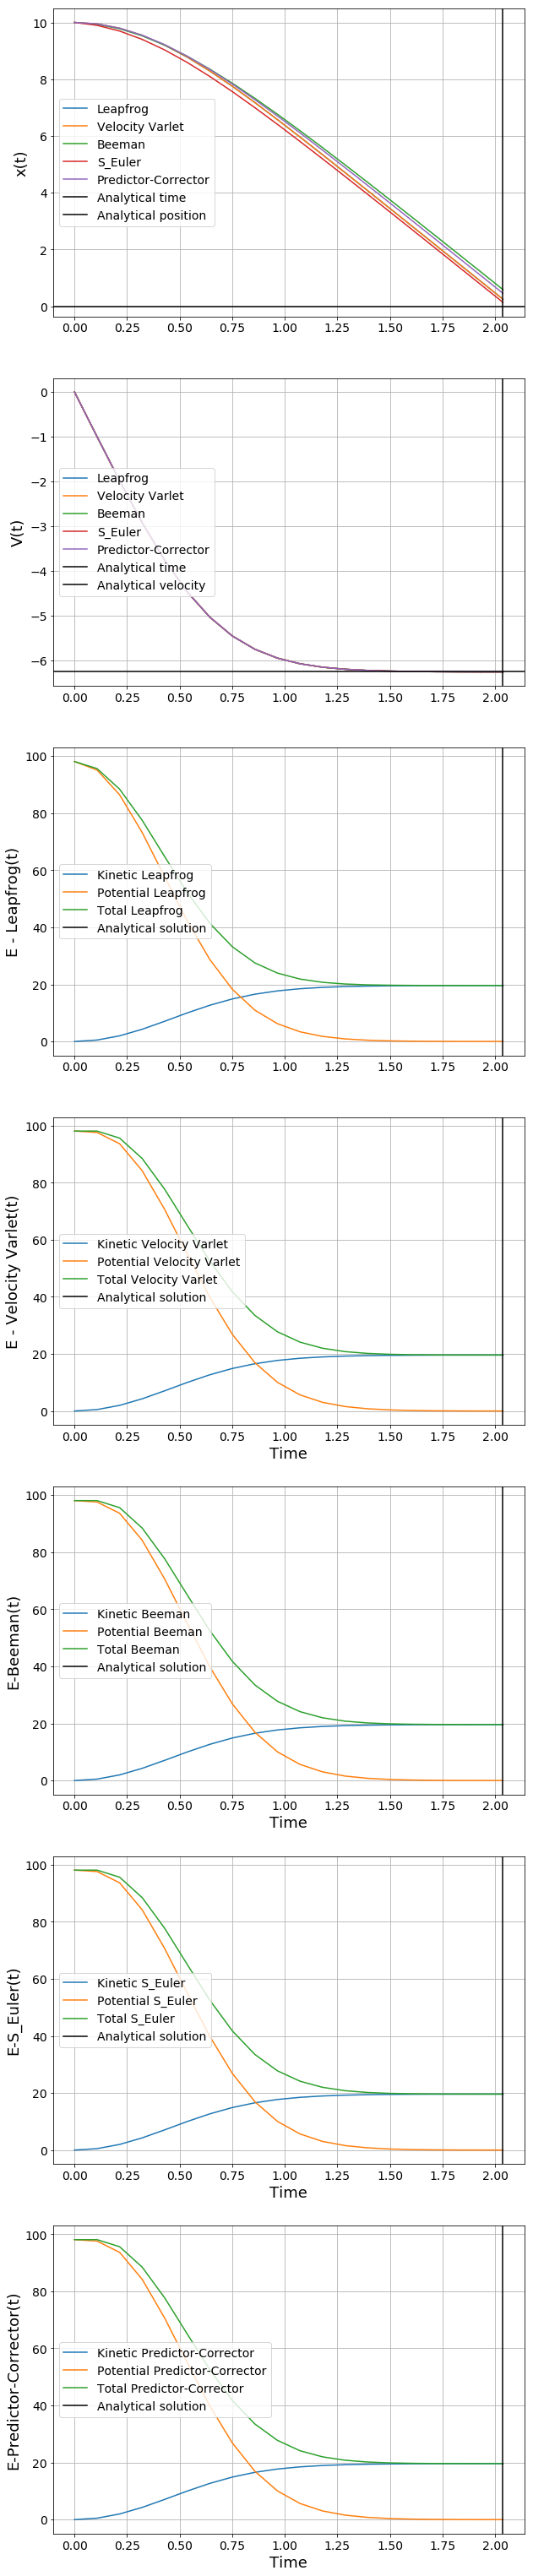

In [383]:
N = 20
x_0 = 10
v_0 = 0
acc = -9.81 #constant
drag_coefs = 0.25
drag_force = True

#Analytical time when object reaches 0m height
if not drag_force:
    analytical_velocity = np.sqrt((-2 * acc * x_0))
    analytical_time = analytical_velocity /(-1*acc)
else:
    analytical_velocity = 6.2430443663133
    analytical_time = 2.037908509576

total_time = analytical_time
t = linspace(0, total_time, N)
dt = total_time / float(N)

###############################################################################
# numerical integration
x1, vh_1, vf_1, Ek1, Ep1, E1 = integrate_LF(acc, x_0, 0.0, dt, N, drag_force, drag_coefs) 
x2, vh_2, vf_2, Ek2, Ep2, E2 = integrate_VV(acc, x_0, 0.0, dt, N, drag_force, drag_coefs) 
x3, vh_3, vf_3, Ek3, Ep3, E3 = integrate_Beeman(acc, x_0, 0.0, dt, N, drag_force, drag_coefs)
x4, vh_4, vf_4, Ek4, Ep4, E4 = integrate_S_Euler(acc, x_0, 0.0, dt, N, drag_force, drag_coefs)
x5, vh_5, vf_5, Ek5, Ep5, E5 = integrate_PC(acc, x_0, 0.0, dt, N, drag_force, drag_coefs)
print(x1[-1], "", vf_1[-1] , " ", t[-1], "Leapfrog      ")
print(x2[-1], "", vf_2[-1] , " ", t[-1], "Velocity Varlet")
print(x3[-1], "", vf_3[-1] , " ", t[-1], "Beeman     ")
print(x4[-1], "", vf_4[-1] , " ", t[-1], "S_Euler    ")
print(x5[-1], "", vf_5[-1] , " ", t[-1], "Predictor-Corrector    ")

###############################################################################
rcParams["axes.grid"] = True
rcParams['font.size'] = 14
rcParams['axes.labelsize'] = 18
figure(figsize = [10, 55])

subplot(711)
plot(t,x1, marker='o', markersize = 0.15, label="Leapfrog")
plot(t,x2, marker='v', markersize = 0.15, label="Velocity Varlet")
plot(t,x3, marker='<', markersize = 0.15, label="Beeman")
plot(t,x4, marker='X', markersize = 0.15, label="S_Euler")
plot(t,x5, marker='D', markersize = 0.15, label="Predictor-Corrector")
axvline(x = analytical_time, label = "Analytical time", c="black")
axhline(y = 0, label = "Analytical position", c="black")
ylabel("x(t)")
legend(loc="center left")

subplot(712)
plot(t,vf_1, marker='o', markersize = 0.05, label="Leapfrog")
plot(t,vf_1, marker='o', markersize = 0.05, label="Velocity Varlet")
plot(t,vf_1, marker='o', markersize = 0.05, label="Beeman")
plot(t,vf_1, marker='o', markersize = 0.05, label="S_Euler")
plot(t,vf_1, marker='o', markersize = 0.05, label="Predictor-Corrector")

axvline(x = analytical_time, label = "Analytical time", c="black")
axhline(y = -1 * analytical_velocity, label = "Analytical velocity", c="black")
ylabel("V(t)")
legend(loc="center left")

subplot(713)
plot(t,Ek1,label=r"Kinetic Leapfrog")
plot(t,Ep1,label=r"Potential Leapfrog")
plot(t,E1,label=r"Total Leapfrog")
axvline(x=analytical_time, label = "Analytical solution", c="black")
ylabel("E - Leapfrog(t)")
legend(loc="center left")

subplot(714)
plot(t,Ek2,label=r"Kinetic Velocity Varlet")
plot(t,Ep2,label=r"Potential Velocity Varlet")
plot(t,E2,label=r"Total Velocity Varlet")
axvline(x=analytical_time, label = "Analytical solution", c="black")
ylabel("E - Velocity Varlet(t)")
xlabel("Time")
legend(loc="center left")

subplot(715)
plot(t,Ek2,label=r"Kinetic Beeman")
plot(t,Ep2,label=r"Potential Beeman")
plot(t,E2,label=r"Total Beeman")
axvline(x=analytical_time, label = "Analytical solution", c="black")
ylabel("E-Beeman(t)")
xlabel("Time")
legend(loc="center left")

subplot(716)
plot(t,Ek2,label=r"Kinetic S_Euler")
plot(t,Ep2,label=r"Potential S_Euler")
plot(t,E2,label=r"Total S_Euler")
axvline(x=analytical_time, label = "Analytical solution", c="black")
ylabel("E-S_Euler(t)")
xlabel("Time")
legend(loc="center left")

subplot(717)
plot(t,Ek2,label=r"Kinetic Predictor-Corrector")
plot(t,Ep2,label=r"Potential Predictor-Corrector")
plot(t,E2,label=r"Total Predictor-Corrector")
axvline(x=analytical_time, label = "Analytical solution", c="black")
ylabel("E-Predictor-Corrector(t)")
xlabel("Time")
legend(loc="center left")

# tight_layout()
show()

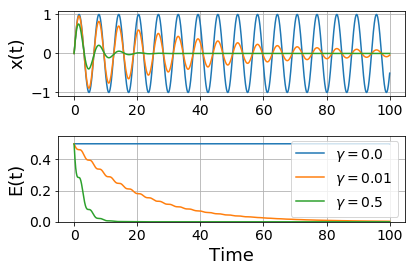

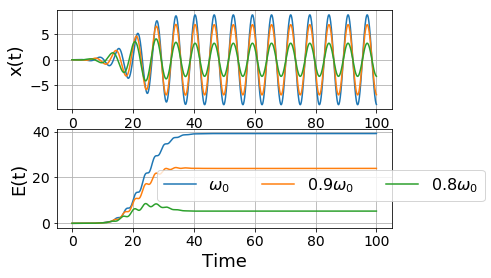

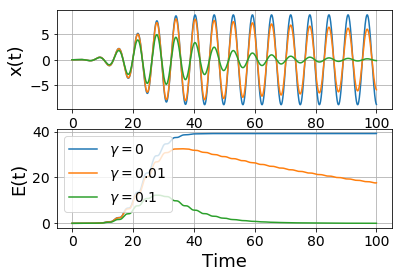

In [351]:
#!/usr/bin/python

from pylab import *

###############################################################################
N = 10000
t = linspace(0,100,N)
dt = t[1] - t[0]

###############################################################################
# functions
def integrate(F,x0,v0,gamma):
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = zeros(N)
    v = zeros(N)
    E = zeros(N)    
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v[0] = v0
    
    ###########################################################################
    # integration
    fac1 = 1.0 - 0.5*gamma*dt
    fac2 = 1.0/(1.0 + 0.5*gamma*dt)
    
    for i in range(N-1):
        v[i + 1] = fac1*fac2*v[i] - fac2*dt*x[i] + fac2*dt*F[i]
        x[i + 1] = x[i] + dt*v[i + 1]
        E[i] = 0.5*(x[i]**2 + ((v[i] + v[i+1])/2.0)**2)
    
    E[-1] = 0.5*(x[-1]**2 + v[-1]**2)
    
    ###########################################################################
    # return solution
    return x,v,E

###############################################################################
# numerical integration
F = zeros(N)
x1,v1,E1 = integrate(F,0.0,1.0,0.0) # x0 = 0.0, v0 = 1.0, gamma = 0.0
x2,v2,E2 = integrate(F,0.0,1.0,0.05) # x0 = 0.0, v0 = 1.0, gamma = 0.01
x3,v3,E3 = integrate(F,0.0,1.0,0.4) # x0 = 0.0, v0 = 1.0, gamma = 0.5

###############################################################################
rcParams["axes.grid"] = True
rcParams['font.size'] = 14
rcParams['axes.labelsize'] = 18
figure()
subplot(211)
plot(t,x1)
plot(t,x2)
plot(t,x3)
ylabel("x(t)")

subplot(212)
plot(t,E1,label=r"$\gamma = 0.0$")
plot(t,E2,label=r"$\gamma = 0.01$")
plot(t,E3,label=r"$\gamma = 0.5$")
ylim(0,0.55)
ylabel("E(t)")

xlabel("Time")
legend(loc="center right")

tight_layout()

###############################################################################
# driven oscillator
def force(f0,t,w,T):
          return f0*cos(w*t)*exp(-t**2/T**2) 

F1 = zeros(N)
F2 = zeros(N)
F3 = zeros(N)
for i in range(N-1):
    F1[i] = force(1.0,t[i] - 20.0,1.0,10.0)
    F2[i] = force(1.0,t[i] - 20.0,0.9,10.0)
    F3[i] = force(1.0,t[i] - 20.0,0.8,10.0)

x1,v1,E1 = integrate(F1,0.0,0.0,0.0)
x2,v2,E2 = integrate(F2,0.0,0.0,0.0)
x3,v3,E3 = integrate(F3,0.0,0.0,0.0)

figure()
subplot(211)
plot(t,x1)
plot(t,x2)
plot(t,x3)
ylabel("x(t)")

subplot(212)
plot(t,E1,label=r"$\omega_0$")
plot(t,E2,label=r"$0.9\omega_0$")
plot(t,E3,label=r"$0.8\omega_0$")
ylabel("E(t)")

xlabel("Time")
rcParams['legend.fontsize'] = 16.0
legend(loc=(0.3,0.27),ncol=3)

###############################################################################
# oscillator driven at resonance plus damping
x1,v1,E1 = integrate(F1,0.0,0.0,0.0)
x2,v2,E2 = integrate(F1,0.0,0.0,0.01)
x3,v3,E3 = integrate(F1,0.0,0.0,0.1)

figure()
subplot(211)
plot(t,x1)
plot(t,x2)
plot(t,x3)
ylabel("x(t)")

subplot(212)
plot(t,E1,label=r"$\gamma = 0$")
plot(t,E2,label=r"$\gamma = 0.01$")
plot(t,E3,label=r"$\gamma = 0.1$")
ylabel("E(t)")

xlabel("Time")
rcParams['legend.fontsize'] = 14.0
legend(loc="upper left")

###############################################################################
show()
###############################################################################

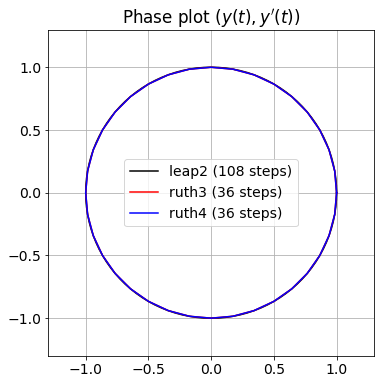

In [341]:
import numpy as np
import matplotlib.pyplot as plt

def symplectic_integrate_step(qvt0, accel, dt, coeffs):
    q,v,t = qvt0
    for ai,bi in coeffs.T:
        v += bi * accel(q,v,t) * dt
        q += ai * v * dt
        t += ai * dt
    return q,v,t

def symplectic_integrate(qvt0, accel, t, coeffs):
    q = np.empty_like(t)
    v = np.empty_like(t)
    qvt = qvt0
    q[0] = qvt[0]
    v[0] = qvt[1]
    for i in range(1, len(t)):
        qvt = symplectic_integrate_step(qvt, accel, t[i]-t[i-1], coeffs)
        q[i] = qvt[0]
        v[i] = qvt[1]
    return q,v

c = np.math.pow(2.0, 1.0/3.0)
ruth4 = np.array([[0.5, 0.5*(1.0-c), 0.5*(1.0-c), 0.5],
                  [0.0,         1.0,          -c, 1.0]]) / (2.0 - c)
ruth3 = np.array([[2.0/3.0, -2.0/3.0, 1.0], [7.0/24.0, 0.75, -1.0/24.0]])
leap2 = np.array([[0.5, 0.5], [0.0, 1.0]])

accel = lambda q,v,t: -q
qvt0 = (1.0, 0.0, 0.0)
tmax = 2.0 * np.math.pi
N = 36

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.axis([-1.3, 1.3, -1.3, 1.3])
ax.set_aspect('equal')
ax.set_title(r"Phase plot $(y(t),y'(t))$")
ax.grid(True)
t = np.linspace(0.0, tmax, 3*N+1)
q,v = symplectic_integrate(qvt0, accel, t, leap2)
ax.plot(q, v, label='leap2 (%d steps)' % (3*N), color='black')
t = np.linspace(0.0, tmax, N+1)
q,v = symplectic_integrate(qvt0, accel, t, ruth3)
ax.plot(q, v, label='ruth3 (%d steps)' % N, color='red')
q,v = symplectic_integrate(qvt0, accel, t, ruth4)
ax.plot(q, v, label='ruth4 (%d steps)' % N, color='blue')
ax.legend(loc='center')
fig.show()
